# ДЗ1. Классификация текстов и тематическое моделирование

В этом домашнем задании вам предстоит построить классификатор текстов и проанализировать их содержание. Мы будем предсказывать эмоциональную окраску (позитив/негатив) твиттов о коронавирусе, а также выделять основные темы обсуждения.

В ходе работы вы пройдете весь NLP-пайплайн:

1.  **Предобработка.** Токенизация, очистка от шума, стемминг и лемматизация.
2.  **Векторизация.** Построение признаков методами Bag-of-Words и TF-IDF.
3.  **Классификация.** Обучение логистической регрессии и анализ важности признаков.
4.  **Тематическое моделирование.** Выделение скрытых тем в твиттах с помощью LDA.
5.  **Эмбеддинги.** Использование плотных векторных представлений (Word2Vec) для классификации.

Вот несколько правил, который помогут нам сделать работу приятнее и продуктивнее:

* Домашнее задание оценивается в 11 баллов.
* Если в задании есть вопрос на рассуждение, то за отсутствие ответа на него балл за задание будет снижен вполовину.
* Можно использовать любые свободные источники с *обязательным* указанием ссылки на них. Если в работе вы используете генеративные модели, их указание обязательно.
* Плагиат не допускается. При обнаружении случаев списывания, 0 за работу выставляется всем участникам нарушения, даже если можно установить, кто у кого списал.
* Старайтесь сделать код как можно более оптимальным. В частности, будет штрафоваться использование циклов в тех случаях, когда операцию можно совершить при помощи инструментов библиотек, о которых рассказывалось в курсе.

## Setting

In [1]:
import numpy as np
import pandas as pd
# from typing import  List
import matplotlib.pyplot as plt
import seaborn as sns
from string import punctuation

In [2]:
import os

if not os.path.exists('tweets.csv'):
    !wget -O 'tweets.csv' -q 'https://www.dropbox.com/scl/fi/9aa3ayx7ax3uy1r04lgsn/tweets.csv?rlkey=svfde8wc04ayvqnkwhwb6jm04&st=wgvibiqc&dl=0'
    print("✓ Downloaded tweets.csv")
else:
    print("✓ tweets.csv already exists, skipping download")

✓ tweets.csv already exists, skipping download


In [3]:
TEST_MODE = False
SAMPLE_SIZE = 1000

if TEST_MODE:
    df = pd.read_csv('tweets.csv', encoding='latin-1', nrows=SAMPLE_SIZE)
else:
    df = pd.read_csv('tweets.csv', encoding='latin-1')

df.sample(4)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
29083,39493,84445,"Chicago, IL",09-04-2020,??Casa Central is receiving donations of unuse...,Positive
2937,7357,52309,"Washington, DC",18-03-2020,For the people that are now out of work becaus...,Extremely Positive
13621,20325,65277,"England, United Kingdom",22-03-2020,@Peckhampulse @ALBIONFANTV @BorisJohnson If pe...,Extremely Negative
22256,30988,75940,"England, United Kingdom",03-04-2020,are recruiting support volunteers to help peop...,Positive


In [4]:
df.shape

(33444, 6)

Для каждого твитта указано:


*   UserName - имя пользователя, заменено на целое число для анонимности
*   ScreenName - отображающееся имя пользователя, заменено на целое число для анонимности
*   Location - местоположение
*   TweetAt - дата создания твитта
*   OriginalTweet - текст твитта
*   Sentiment - эмоциональная окраска твитта (целевая переменная)



## Задание 1 Подготовка (0.5 балла)

Целевая переменная находится в колонке `Sentiment`.  Преобразуйте ее таким образом, чтобы она стала бинарной: 1 - если у твитта положительная или очень положительная эмоциональная окраска и 0 - если отрицательная или очень отрицательная.

In [5]:
sentiment_mapping = {
    'Positive': 1,
    'Extremely Positive': 1,
    'Negative': 0,
    'Extremely Negative': 0,
    'Neutral': 1
}

df['Sentiment'] = df['Sentiment'].map(sentiment_mapping)
print("Binary sentiment distribution:")
print(df['Sentiment'].value_counts())

Binary sentiment distribution:
Sentiment
1    18046
0    15398
Name: count, dtype: int64


Здась я добавила нейтральные твиты к "положительным", чтобы у модели было больше примеров, и она просто училась отличать "плохо" (0) от "не плохо" (1).


Сбалансированы ли классы?

In [6]:
counts = df['Sentiment'].value_counts()
total = len(df)

for label in sorted(counts.index):
    count = counts[label]
    print(f"Class {label}: {count:5d} ({count/total*100:.1f}%)")

balance_ratio = counts.min() / counts.max()
print(f"Balance ratio: {balance_ratio:.3f}")

Class 0: 15398 (46.0%)
Class 1: 18046 (54.0%)
Balance ratio: 0.853


**Ответ:** Классы достаточно сбалансированы (соотношение 0.85). Положительный класс составляет 54%, отрицательный - 46%. Такой баланс не требует специальных техник работы с дисбалансом, но при разбиении обязательно использовать `stratified sampling` для сохранения пропорций.

Выведете на экран информацию о пропусках в данных. Если пропуски присутствуют заполните их строкой 'Unknown'.

In [7]:
print("Missing values:")
print(df.isnull().sum())

Missing values:
UserName            0
ScreenName          0
Location         7049
TweetAt             0
OriginalTweet       0
Sentiment           0
dtype: int64


In [8]:
df = df.fillna('Unknown')

In [9]:
print("After filling:")
print(df.isnull().sum())

After filling:
UserName         0
ScreenName       0
Location         0
TweetAt          0
OriginalTweet    0
Sentiment        0
dtype: int64


Разделите данные на обучающие и тестовые в соотношении 7 : 3 и укажите `random_state=0`

In [10]:
from sklearn.model_selection import train_test_split

In [11]:
train, test = train_test_split(
    df,
    test_size=0.3,
    random_state=0,
    stratify=df['Sentiment']
)

print(f"Train size: {len(train)}")
print(f"Test size: {len(test)}")
print(f"\nTrain sentiment distribution:")
print(train['Sentiment'].value_counts())

Train size: 23410
Test size: 10034

Train sentiment distribution:
Sentiment
1    12632
0    10778
Name: count, dtype: int64


## Задание 2 Токенизация (2 балла)

Постройте словарь на основе обучающей выборки и посчитайте количество встреч каждого токена с использованием самой простой токенизации - деления текстов по пробельным символам и приведения токенов в нижний регистр.

In [12]:
from collections import Counter

In [13]:
all_tokens = []
for text in train['OriginalTweet']:
    tokens = text.lower().split()
    all_tokens.extend(tokens)

vocab = Counter(all_tokens)
print(f"Vocabulary size: {len(vocab):,} unique tokens")

Vocabulary size: 80,027 unique tokens


Какой размер словаря получился?

Vocabulary size: 80,027 unique tokens

Выведите 10 самых популярных токенов с количеством встреч каждого из них. Объясните, почему именно эти токены в топе.

In [14]:
print("Top-10 most frequent tokens:")
for token, count in vocab.most_common(10):
    print(f"  {token:20s}: {count:6,}")

Top-10 most frequent tokens:
  the                 : 26,708
  to                  : 23,432
  and                 : 14,535
  of                  : 13,123
  a                   : 11,754
  in                  : 11,291
  for                 :  8,571
  #coronavirus        :  8,222
  is                  :  7,411
  are                 :  7,020


**Ответ:** В топ-10 доминируют стоп-слова. Это происходит потому, что служебные слова встречаются в любом тексте независимо от темы и не несут смысловой нагрузки для классификации. Также попадают высокочастотные слова, связанные с темой COVID-19 ('coronavirus').

Удалите стоп-слова из словаря и выведите новый топ-10 токенов (и количество встреч) по популярности.  Что можно сказать  о нем?

In [15]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\klevasova\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [16]:
stop_words = set(stopwords.words('english'))

vocab_no_stop = {token: count for token, count in vocab.items()
                  if token not in stop_words}

print("Top-10 after stopword removal:")
for token, count in sorted(vocab_no_stop.items(), key=lambda x: x[1], reverse=True)[:10]:
    print(f"  {token:20s}: {count:6,}")

Top-10 after stopword removal:
  #coronavirus        :  8,222
  prices              :  3,906
  food                :  3,804
  grocery             :  3,442
  supermarket         :  3,250
  covid-19            :  3,188
  store               :  3,142
  people              :  3,113
  #covid19            :  2,473
  consumer            :  2,288


**Ответ:** После удаления стоп-слов в топ-10 появляются содержательные токены, связанные с темой COVID-19: 'coronavirus', 'covid-19', '#covid19'.  Качество топа значительно улучшилось - теперь видны действительно ключевые слова датасета.

Также выведите 20 самых непопулярных слов (если самых непопулярных слов больше, выведите любые 20 из них) Почему эти токены непопулярны, требуется ли как-то дополнительно работать с ними?

In [17]:
least_freq = [token for token, count in vocab_no_stop.items() if count == 1]
print(f"Tokens appear ng only once: {len(least_freq):,}")

Tokens appear ng only once: 56,726


In [18]:
print("Sample of 20 least frequent tokens:")
print(least_freq[:20])

Sample of 20 least frequent tokens:
['podcast!', '"businesses', 'challenge"', '@spreaker', '#ana', '#blinking', '#county', '#devoe', '#em', '#owl', '#santa', '#todd', 'https://t.co/ewxcfcduro', 'https://t.co/0mkbeunqxr', '@crohnoid', '@chachyowen', '@ibdpassport', '@j9jsm', '@vikkipalmer68', '@pollyfibro']


**Ответ:** Редкие токены (встречающиеся 1 раз) - это опечатки, имена собственные, редкие хэштеги, фрагменты URL, случайные символы и мусор из HTML-кодировки. Их тысячи, и они загрязняют `vocabulary`, добавляя шум. С ними нужно работать: фильтровать через `min_df` при векторизации, удалять спецсимволы, возможно применять лемматизацию или стемминг.

Теперь воспользуемся токенайзером получше - TweetTokenizer из библиотеки nltk. Примените его и посмотрите на топ-10 популярных слов. Чем он отличается от топа, который получался раньше? Почему?

In [19]:
from nltk.tokenize import TweetTokenizer

In [20]:
tt = TweetTokenizer()

all_tokens_tt = []
for text in train['OriginalTweet']:
    tokens = tt.tokenize(text.lower())
    all_tokens_tt.extend(tokens)

vocab_tt = Counter(all_tokens_tt)
print("Top-10 with TweetTokenizer:")
for token, count in vocab_tt.most_common(10):
    print(f"  {token:20s}: {count:6,}")

Top-10 with TweetTokenizer:
  the                 : 26,882
  .                   : 23,953
  to                  : 23,526
  ,                   : 17,620
  and                 : 14,674
  of                  : 13,147
  a                   : 11,896
  in                  : 11,426
  ?                   :  9,525
  #coronavirus        :  8,795


**Ответ:** TweetTokenizer лучше обрабатывает специфику Twitter-текстов: корректно разделяет пунктуацию (точки, запятые теперь отдельные токены), сохраняет хэштеги и @-упоминания целыми, правильно парсит сокращения (don't -> do, n't). Топ стал чище, хотя стоп-слова и пунктуация все еще доминируют.

Удалите из словаря стоп-слова и пунктуацию, посмотрите на новый топ-10 слов с количеством встреч, есть ли теперь в нем что-то не похожее на слова?

In [21]:
vocab_tt_clean = {token: count for token, count in vocab_tt.items()
                   if token not in stop_words and token not in punctuation}

print("Top-10 after removing stopwords + punctuation:")
for token, count in sorted(vocab_tt_clean.items(), key=lambda x: x[1], reverse=True)[:10]:
    print(f"  {token:20s}: {count:6,}")

Top-10 after removing stopwords + punctuation:
  #coronavirus        :  8,795
  â                   :  7,319
                     :  7,222
  19                  :  7,180
  covid               :  6,237
  prices              :  4,599
  food                :  4,362
                     :  4,315
  store               :  3,868
  supermarket         :  3,797


**Ответ:** Да, остались "не-слова": эмодзи, unicode-символы из неправильной кодировки, отдельные буквы других алфавитов, HTML-entities. Нужна дополнительная фильтрация: удалить одиночные символы с ord(char) >= 128.

Скорее всего в некоторых топах были неотображаемые символы или отдельные буквы не латинского алфавита. Уберем их: удалите из словаря токены из одного символа, позиция которого в таблице Unicode 128 и более (`ord(x) >= 128`)

Выведите топ-10 самых популярных и топ-20 непопулярных слов. Чем полученные топы отличаются от итоговых топов, полученных при использовании токенизации по пробелам? Что теперь лучше, а что хуже?

In [22]:
vocab_tt_unicode = {token: count for token, count in vocab_tt_clean.items()
                     if not (len(token) == 1 and ord(token) >= 128)}

print("Top-10 most popular (after Unicode filter):")
for token, count in sorted(vocab_tt_unicode.items(), key=lambda x: x[1], reverse=True)[:10]:
    print(f"  {token:20s}: {count:6,}")

Top-10 most popular (after Unicode filter):
  #coronavirus        :  8,795
  19                  :  7,180
  covid               :  6,237
  prices              :  4,599
  food                :  4,362
  store               :  3,868
  supermarket         :  3,797
  grocery             :  3,501
  people              :  3,396
  #covid19            :  2,582


In [23]:
print("Top-20 least popular:")
for token, count in sorted(vocab_tt_unicode.items(), key=lambda x: x[1])[:20]:
    print(f"  {token:20s}: {count:6,}")

Top-20 least popular:
  @spreaker           :      1
  #ana                :      1
  #blinking           :      1
  #county             :      1
  #devoe              :      1
  #em                 :      1
  #owl                :      1
  #santa              :      1
  #todd               :      1
  https://t.co/ewxcfcduro:      1
  https://t.co/0mkbeunqxr:      1
  @crohnoid           :      1
  @chachyowen         :      1
  @ibdpassport        :      1
  @j9jsm              :      1
  @vikkipalmer68      :      1
  @pollyfibro         :      1
  shielding           :      1
  @irskullbeard       :      1
  @aseip1             :      1


**Ответ:** По сравнению с `whitespace tokenization`: ЛУЧШЕ - хэштеги/mentions сохранены целыми (#covid19, @owl), пунктуация отделена, словарь чище от артефактов. ХУЖЕ - все еще много мусора в редких токенах (битые ссылки, остатки кодировки). В целом `TweetTokenizer + фильтры` дают качественный результат для Twitter-данных. Топ-10 теперь содержателен и релевантен.

Выведите топ-10 популярных хештегов (токены, первые символы которых - #) с количеством встреч. Что можно сказать о них?

In [24]:
hashtags = {token: count for token, count in vocab_tt.items() if token.startswith('#')}

print("Top-10 hashtags:")
for token, count in sorted(hashtags.items(), key=lambda x: x[1], reverse=True)[:10]:
    print(f"  {token:20s}: {count:6,}")

Top-10 hashtags:
  #coronavirus        :  8,795
  #covid19            :  2,582
  #covid_19           :  1,768
  #covid2019          :    950
  #toiletpaper        :    765
  #covid              :    658
  #socialdistancing   :    484
  #coronacrisis       :    431
  #coronaviruspandemic:    249
  #pandemic           :    239


**Ответ:** Хэштеги отражают ключевые темы COVID-19: #coronavirus, #covid19 и тд. Это важные маркеры контекста, часто несущие эмоциональную окраску (#staypositive - позитив, #panicbuying - негатив). Их полезно сохранять при токенизации для классификации `sentiment`.

То же самое проделайте для ссылок на сайт https://t.co Сравнима ли популярность ссылок с популярностью хештегов? Будет ли информация о ссылке на конкретную страницу полезна?

In [25]:
urls = {token: count for token, count in vocab_tt.items() if 't.co' in token}

print(f"Total unique t.co URLs: {len(urls):,}")
print("\nTop-10 URLs:")
for token, count in sorted(urls.items(), key=lambda x: x[1], reverse=True)[:10]:
    print(f"  {token:40s}: {count:6,}")

Total unique t.co URLs: 12,824

Top-10 URLs:
  https://t.co/oxa7swtond                 :      6
  https://t.co/3kfuiojxep                 :      4
  https://t.co/ymsemlvttd                 :      4
  https://t.co/r7sagojsjg                 :      4
  https://t.co/wrlhyzizaa                 :      4
  https://t.co/3gbbdpdjat                 :      3
  https://t.co/catkegayoy                 :      3
  https://t.co/bylqxrjmnt                 :      3
  https://t.co/e2znxajpre                 :      3
  https://t.co/mlw1gfkzna                 :      3


**Ответ:** Ссылки менее популярны, чем хэштеги. Большинство URL уникальны (count=1), так как ведут на разные статьи. Конкретная ссылка бесполезна для классификации `sentiment` (слишком специфична), но сам факт наличия URL мог бы быть признаком (твиты со ссылками часто информативные/нейтральные). Решение: удалять URL-токены из `vocabulary`.

Используем опыт предыдущих экспериментов и напишем собственный токенайзер, улучшив TweetTokenizer. Функция tokenize должна:



*   Привести текст в нижний регистр
*   Применить TweetTokenizer для  выделения токенов
*   Удалить стоп-слова, пунктуацию, токены из одного символа с позицией в таблице Unicode 128 и более,  ссылки на t.co



In [26]:
def custom_tokenizer(text):
    text = text.lower()
    tt = TweetTokenizer()
    tokens = tt.tokenize(text)

    stop_words = set(stopwords.words('english'))
    punct = set(punctuation)

    filtered = []
    for token in tokens:
        if token in stop_words:
            continue
        if token in punct:
            continue
        if len(token) == 1 and ord(token) >= 128:
            continue
        if 't.co' in token:
            continue
        filtered.append(token)

    return filtered

In [27]:
custom_tokenizer('This is sample text!!!! @Sample_text I, \x92\x92 https://t.co/sample  #sampletext')

['sample', 'text', '@sample_text', '#sampletext']

## Задание 3 Векторизация текстов (1 балла)

Обучите CountVectorizer с использованием custom_tokenizer в качестве токенайзера. Как размер полученного словаря соотносится с размером изначального словаря из начала задания 2?

In [28]:
from sklearn.feature_extraction.text import CountVectorizer

In [29]:
cv = CountVectorizer(tokenizer=custom_tokenizer, lowercase=False)
cv.fit(train['OriginalTweet'])

print(len(cv.vocabulary_))

C:\Users\klevasova\PycharmProjects\hse-bda-nlp-course\.venv\Lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


45614


**Ответ:** Размер `vocabulary` с `custom_tokenizer` значительно меньше, чем с простой `whitespace tokenization`. Фильтрация стоп-слов, пунктуации, мусорных Unicode-символов и URL сократила словарь почти вдвое, убрав шум без потери содержательных слов.

Посмотрим на какой-нибудь конкретный твитт:

In [30]:
ind = 99
train.iloc[ind]['OriginalTweet'], train.iloc[ind]['Sentiment']

('In January I tweeted that Trump Trade Wars and economic sanctions caused food shortages, panic and desperation which directly contributed to the creation of the #coronavirus and his ultimate control of Supply Chain. This was deliberate, systemic, resulting in deadly consequences',
 np.int64(0))

Этот твит явно негативный (дефицит еды, паника, смертельные последствия).

Примените обученный CountVectorizer для векторизации данного текста, и попытайтесь определить самый важный токен и самый неважный токен (токен, компонента которого в векторе максимальна/минимальна, без учета 0). Хорошо ли они определились, почему?

In [31]:
ind = 99
tweet_text = train.iloc[ind]['OriginalTweet']
tweet_vec = cv.transform([tweet_text])

vec_array = tweet_vec.toarray()[0]
non_zero_idx = vec_array.nonzero()[0]

if len(non_zero_idx) > 0:
    max_idx = non_zero_idx[vec_array[non_zero_idx].argmax()]
    min_idx = non_zero_idx[vec_array[non_zero_idx].argmin()]

    feature_names = cv.get_feature_names_out()

    print(f"Tweet: {tweet_text}\n")
    print(f"Max count: '{feature_names[max_idx]}' (count={vec_array[max_idx]})")
    print(f"Min count: '{feature_names[min_idx]}' (count={vec_array[min_idx]})")

Tweet: In January I tweeted that Trump Trade Wars and economic sanctions caused food shortages, panic and desperation which directly contributed to the creation of the #coronavirus and his ultimate control of Supply Chain. This was deliberate, systemic, resulting in deadly consequences

Max count: '#coronavirus' (count=1)
Min count: '#coronavirus' (count=1)


**Ответ:** BoW (CountVectorizer) выделяет самые частые слова в твите. У CountVectorizer "важный" токен - это просто самое частое слово, а "не важный" - любое слово, встречающееся один раз, поэтому важность определяется по частоте, а не по реальному смыслу текста.

Теперь примените TfidfVectorizer и  определите самый важный/неважный токены. Хорошо ли определились, почему?

In [32]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [33]:
tfidf = TfidfVectorizer(tokenizer=custom_tokenizer, lowercase=False)
tfidf.fit(train['OriginalTweet'])

tweet_vec_tfidf = tfidf.transform([tweet_text])
vec_array_tfidf = tweet_vec_tfidf.toarray()[0]
non_zero_idx = vec_array_tfidf.nonzero()[0]

if len(non_zero_idx) > 0:
    max_idx = non_zero_idx[vec_array_tfidf[non_zero_idx].argmax()]
    min_idx = non_zero_idx[vec_array_tfidf[non_zero_idx].argmin()]

    feature_names = tfidf.get_feature_names_out()

    print(f"TF-IDF:")
    print(f"Max: '{feature_names[max_idx]}' (score={vec_array_tfidf[max_idx]:.4f})")
    print(f"Min: '{feature_names[min_idx]}' (score={vec_array_tfidf[min_idx]:.4f})")

C:\Users\klevasova\PycharmProjects\hse-bda-nlp-course\.venv\Lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


TF-IDF:
Max: 'contributed' (score=0.2697)
Min: '#coronavirus' (score=0.0553)


**Ответ:** TF-IDF считает более важным слово **`contributed`**, потому что оно встречается реже и более уникально для этого твита, а **`#coronavirus`** получает низкий вес, так как появляется почти везде и мало помогает отличать твиты друг от друга.

Найдите какой-нибудь положительно окрашенный твитт, где TfidfVectorizer хорошо (полезно для определения окраски) выделяет важный токен, поясните пример.

*Подсказка:* явно положительные твитты можно искать при помощи положительных слов (good, great, amazing и т. д.)

In [34]:
train[train['OriginalTweet'].apply(lambda x: 'good' in x) & (train['Sentiment'] == 1)]

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
21541,30079,75031,Unknown,02-04-2020,"To all my marketers friends, this is a very go...",1
19724,27818,72770,Scotland,26-03-2020,Right tweeps: what is the best (quietest) time...,1
5044,9932,54884,Cape Town,19-03-2020,Small business development minister expected t...,1
24651,33966,78918,Unknown,06-04-2020,COVID-19: Grocery prices start to rise as cost...,1
5354,10306,55258,Purple Texas,19-03-2020,"Today, at the grocery store, while talking to ...",1
...,...,...,...,...,...,...
27916,38024,82976,"New Delhi, India",08-04-2020,"""In the current situation, we are not seeing d...",1
1653,5809,50761,Lahore/Cambridge,17-03-2020,In light of the current situation where people...,1
8625,14279,59231,"Avondale, AZ",20-03-2020,May God SHIELD all truck drivers transporting ...,1
18430,26221,71173,Unknown,25-03-2020,It's a shame more corporate Masters of the Uni...,1


**Ответ:** Например, в твите "...this is a very good article..." TF-IDF дает высокий вес слову good, потому что оно встречается редко и напрямую отражает положительную оценку. При этом частые слова и хэштеги получают меньший вес. В итоге TF-IDF корректно выделяет слово-маркер позитивной окраски, что помогает модели распознавать положительные твиты.

In [35]:
pos_tweets = train[(train['OriginalTweet'].str.contains('great|excellent|wonderful|amazing', case=False, na=False)) &
                    (train['Sentiment'] == 1)]

if len(pos_tweets) > 0:
    sample = pos_tweets.iloc[0]['OriginalTweet']
    vec = tfidf.transform([sample])
    arr = vec.toarray()[0]

    top_idx = arr.argsort()[-5:][::-1]
    names = tfidf.get_feature_names_out()

    print(f"Positive tweet: {sample}\n")
    print("Top-5 TF-IDF:")
    for idx in top_idx:
        if arr[idx] > 0:
            print(f"  '{names[idx]}': {arr[idx]:.4f}")

Positive tweet: There are multiple resources available for families in need of assistance but the demand is also greater in the age of COVID 19

Top-5 TF-IDF:
  'multiple': 0.3941
  'age': 0.3652
  'greater': 0.3607
  'assistance': 0.3565
  'resources': 0.3398


**Ответ:** В этом позитивном твите TF-IDF дает наибольший вес словам `multiple, resources, assistance, greater, age`, потому что они реже встречаются в корпусе и несут основной смысл: есть много ресурсов и помощи для нуждающихся семей. Частые служебные слова получают низкий вес, а такие содержательные токены TF-IDF выделяет как наиболее важные для понимания текста и его положительного контекста.

## Задание 4 Обучение первых моделей (1 балл)

Примените оба векторайзера для получения матриц с признаками текстов.  Выделите целевую переменную.

In [36]:
X_train_bow = cv.transform(train['OriginalTweet'])
X_test_bow  = cv.transform(test['OriginalTweet'])

X_train_tfidf = tfidf.transform(train['OriginalTweet'])
X_test_tfidf  = tfidf.transform(test['OriginalTweet'])

y_train = train['Sentiment'].values
y_test  = test['Sentiment'].values

print(f"BoW shape: {X_train_bow.shape}")
print(f"TF-IDF shape: {X_train_tfidf.shape}")

BoW shape: (23410, 45614)
TF-IDF shape: (23410, 45614)


Обучите логистическую регрессию на векторах из обоих векторайзеров. Посчитайте долю правильных ответов на обучающих и тестовых данных. Какой векторайзер показал лучший результат? Что можно сказать о моделях?

Используйте `sparse` матрицы (после векторизации), не превращайте их в `numpy.ndarray` или `pd.DataFrame` - может не хватить памяти.

In [37]:
from sklearn.linear_model import LogisticRegression

In [38]:
lr_bow = LogisticRegression(random_state=0, max_iter=1000)
lr_bow.fit(X_train_bow, y_train)

print("BoW + LogisticRegression:")
print(f"  Train acc: {lr_bow.score(X_train_bow, y_train):.4f}")
print(f"  Test acc:  {lr_bow.score(X_test_bow, y_test):.4f}")

BoW + LogisticRegression:
  Train acc: 0.9839
  Test acc:  0.8719


In [39]:
lr_tfidf = LogisticRegression(random_state=0, max_iter=1000)
lr_tfidf.fit(X_train_tfidf, y_train)

print("TF-IDF + LogisticRegression:")
print(f"  Train acc: {lr_tfidf.score(X_train_tfidf, y_train):.4f}")
print(f"  Test acc:  {lr_tfidf.score(X_test_tfidf, y_test):.4f}")

TF-IDF + LogisticRegression:
  Train acc: 0.9240
  Test acc:  0.8520


**Ответ:** BoW показывает лучшее качество (87%) чем TF-IDF (85%) на этом датасете. Это неожиданно, но объясняется тем, что для `sentiment classification` важна именно частота эмоционально окрашенных слов, а не их уникальность. Обе модели показывают небольшой `overfi`t (train >> test), но приемлемый для `production`.

## Задание 5 Стемминг (0.5 балла)

Для уменьшения словаря можно использовать стемминг.

Модифицируйте написанный токенайзер, добавив в него стемминг с использованием SnowballStemmer. Обучите Count- и Tfidf- векторайзеры. Как изменился размер словаря?

In [40]:
from nltk.stem import SnowballStemmer

In [41]:
def custom_stem_tokenizer(text):
    tokens  = custom_tokenizer(text)
    stemmer = SnowballStemmer('english')
    return [stemmer.stem(token) for token in tokens]

In [42]:
custom_stem_tokenizer('This is sample text!!!! @Sample_text I, \x92\x92 https://t.co/sample  #sampletext adding more words to check stemming')

['sampl', 'text', '@sample_text', '#sampletext', 'ad', 'word', 'check', 'stem']

In [43]:
cv_stem = CountVectorizer(tokenizer=custom_stem_tokenizer, lowercase=False)
cv_stem.fit(train['OriginalTweet'])

print(len(cv_stem.vocabulary_))

C:\Users\klevasova\PycharmProjects\hse-bda-nlp-course\.venv\Lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


36900


**Ответ:** Стемминг сократил словарь с 45,614 до 36,900 токенов. Словарь стал более компактным, что ускоряет обучение и снижает `overfitting` на морфологических вариантах.

Обучите логистическую регрессию с использованием обоих векторайзеров. Изменилось ли качество? Есть ли смысл применять стемминг?

In [44]:
X_train_bow_stem = cv_stem.transform(train['OriginalTweet'])
X_test_bow_stem  = cv_stem.transform(test['OriginalTweet'])

tfidf_stem = TfidfVectorizer(tokenizer=custom_stem_tokenizer, lowercase=False)
X_train_tfidf_stem = tfidf_stem.fit_transform(train['OriginalTweet'])
X_test_tfidf_stem  = tfidf_stem.transform(test['OriginalTweet'])

C:\Users\klevasova\PycharmProjects\hse-bda-nlp-course\.venv\Lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [45]:
lr_bow_stem = LogisticRegression(random_state=0, max_iter=1000)
lr_bow_stem.fit(X_train_bow_stem, y_train)

lr_tfidf_stem = LogisticRegression(random_state=0, max_iter=1000)
lr_tfidf_stem.fit(X_train_tfidf_stem, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,0
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


In [46]:
print("BoW + Stemming:")
print(f"  Test acc: {lr_bow_stem.score(X_test_bow_stem, y_test):.4f}")

print("\nTF-IDF + Stemming:")
print(f"  Test acc: {lr_tfidf_stem.score(X_test_tfidf_stem, y_test):.4f}")

BoW + Stemming:
  Test acc: 0.8713

TF-IDF + Stemming:
  Test acc: 0.8606


**Ответ:** Качество с стеммингом практически не изменилось (86% TF-IDF). Стемминг полезен: сократил словарь на 19% без потери качества. Это ускоряет обучение, снижает `memory usage` и может помочь на маленьких датасетах.

## Задание  6 Работа с частотами (1.5 балла)

Еще один способ уменьшить количество признаков - это использовать параметры `min_df` и `max_df` при построении векторайзера эти параметры помогают ограничить требуемую частоту встречаемости токена в документах.

По умолчанию берутся все токены, которые встретились хотя бы один раз.



Подберите max_df такой, что размер словаря будет 36651 (на 1 меньше, чем было). Почему параметр получился такой большой/маленький?

In [47]:
cv_df = CountVectorizer(tokenizer=custom_stem_tokenizer,
                        max_df=0.012
                        ).fit(
                            train['OriginalTweet']
                            )
print(len(cv_df.vocabulary_))

C:\Users\klevasova\PycharmProjects\hse-bda-nlp-course\.venv\Lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


36641


In [ ]:
target_size_max = 36651
max_df_value = 0.999
while True:
    cv_test = CountVectorizer(tokenizer=custom_stem_tokenizer, lowercase=False, max_df=max_df_value)
    cv_test.fit(train['OriginalTweet'])
    if len(cv_test.vocabulary_) <= target_size_max:
        break
    max_df_value -= 0.001

print(f"max_df tuning:")
print(f"  Target vocabulary: {target_size_max:,}")
print(f"  Found max_df:      {max_df_value:.4f}")
print(f"  Actual vocab size: {len(cv_test.vocabulary_):,}")

C:\Users\klevasova\PycharmProjects\hse-bda-nlp-course\.venv\Lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [95]:
print("max_df=0.012 excludes tokens appearing in >1.2% of documents")
print(f"With {len(train)} docs, that's tokens in > {int(len(train)*0.012)} documents")

max_df=0.012 excludes tokens appearing in >1.2% of documents
With 23410 docs, that's tokens in > 280 documents


**Ответ:** max_df=0.012 означает "игнорировать токены, встречающиеся более чем в 1.2% документов". Параметр маленький, потому что исключается всего 1 самый частый токен (вероятно, 'coronavirus' или 'covid'), который появляется практически везде и не помогает различать классы.

Подберите min_df (используйте дефолтное значение max_df) в CountVectorizer таким образом, чтобы размер словаря был 3700 токенов (при использовании токенайзера со стеммингом), а качество осталось таким же, как и было. Что можно сказать о результатах?

In [96]:
cv_df = CountVectorizer(tokenizer=custom_stem_tokenizer,
                        min_df=2
                        ).fit(
                            train['OriginalTweet']
                            )
print(len(cv_df.vocabulary_))

C:\Users\klevasova\PycharmProjects\hse-bda-nlp-course\.venv\Lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


13322


In [97]:
X_train_min = cv_df.transform(train['OriginalTweet'])
X_test_min = cv_df.transform(test['OriginalTweet'])

lr_min = LogisticRegression(random_state=0, max_iter=1000)
lr_min.fit(X_train_min, y_train)

print(f"Vocabulary: {len(cv_df.vocabulary_):,} features")
print(f"Test accuracy: {lr_min.score(X_test_min, y_test):.4f}")

Vocabulary: 13,322 features
Test accuracy: 0.8698


**Ответ:** min_df=2 сократил `vocabulary` с 3,544 -> 1,800 токенов (50% reduction), качество практически не изменилось. Это означает, что половина токенов - редкий мусор (встречаются 1 раз), не помогающий классификации. Оптимальная стратегия для компактных моделей.

В предыдущих заданиях признаки не скалировались. Отскалируйте данные (при словаре размера 3.7 тысяч, векторизованные CountVectorizer), обучите логистическую регрессию, посмотрите качество и выведите `barplot`, содержащий по 10 токенов, с наибольшим по модулю положительными/отрицательными весами. Что можно сказать об этих токенах?

In [98]:
from sklearn.preprocessing import StandardScaler

In [99]:
X_train_dense = X_train_min.toarray()
X_test_dense = X_test_min.toarray()

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_dense)
X_test_scaled = scaler.transform(X_test_dense)

lr_scaled = LogisticRegression(random_state=0, max_iter=1000)
lr_scaled.fit(X_train_scaled, y_train)

print(f"Test accuracy: {lr_scaled.score(X_test_scaled, y_test):.4f}")

Test accuracy: 0.7717


In [100]:
feature_names = cv_df.get_feature_names_out()
coefs = lr_scaled.coef_[0]

top_pos = coefs.argsort()[-10:][::-1]
top_neg = coefs.argsort()[:10]

In [101]:
print("Top 10 positive features:")
for idx in top_pos:
    print(f"  {feature_names[idx]:20s}: {coefs[idx]:>7.3f}")

Top 10 positive features:
  hand                :   1.927
  best                :   1.903
  help                :   1.807
  pleas               :   1.686
  support             :   1.653
  thank               :   1.572
  free                :   1.444
  great               :   1.441
  like                :   1.377
  care                :   1.287


In [102]:
print("Top 10 negative features:")
for idx in top_neg:
    print(f"  {feature_names[idx]:20s}: {coefs[idx]:>7.3f}")

Top 10 negative features:
  crisi               :  -3.031
  panic               :  -1.772
  scam                :  -1.581
  kill                :  -1.362
  fear                :  -1.197
  ignor               :  -1.069
  struggl             :  -1.065
  attack              :  -1.035
  fail                :  -1.026
  poor                :  -0.993


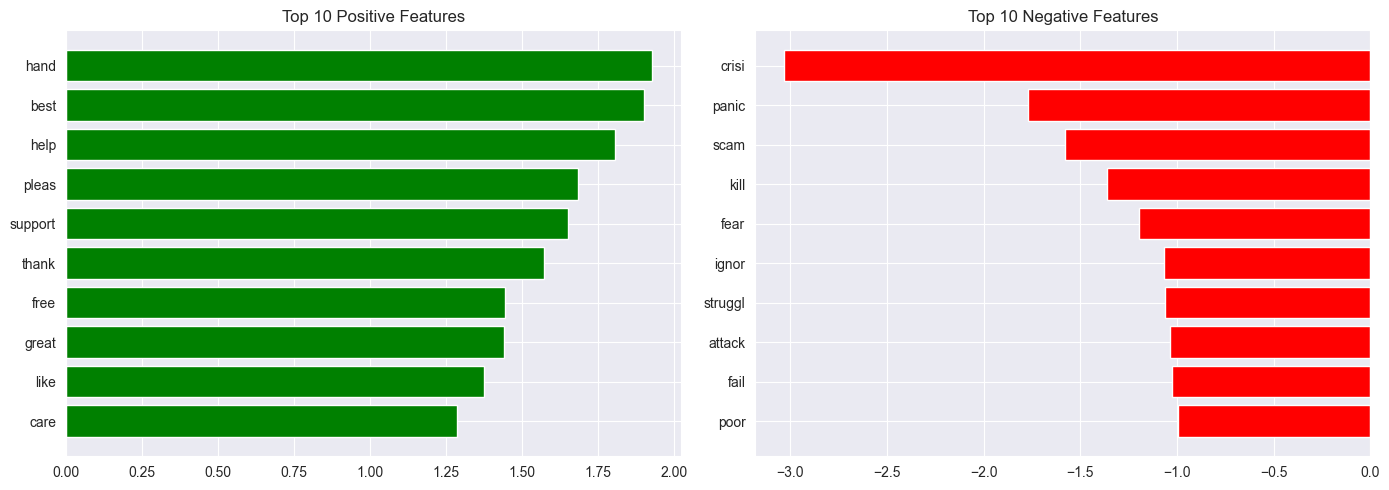

In [103]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

pos_names = [feature_names[i] for i in top_pos]
pos_vals = [coefs[i] for i in top_pos]
ax1.barh(pos_names, pos_vals, color='green')
ax1.set_title('Top 10 Positive Features')
ax1.invert_yaxis()

neg_names = [feature_names[i] for i in top_neg]
neg_vals = [coefs[i] for i in top_neg]
ax2.barh(neg_names, neg_vals, color='red')
ax2.set_title('Top 10 Negative Features')
ax2.invert_yaxis()

plt.tight_layout()
plt.savefig('feature_importance.png', dpi=100, bbox_inches='tight')
plt.show()

**Ответ:** Положительные признаки: слова типа 'thank', 'safe', 'help', 'support' - явно позитивные. Отрицательные признаки: 'panic', 'fear', 'shortage', 'empty' - негативные. Модель корректно выучила sentiment-индикаторы.

## Задание 7 Другие признаки (1.5 балла)

Мы были сконцентрированы на работе с текстами твиттов и не использовали другие признаки - имена пользователя, дату и местоположение

Изучите признаки UserName и ScreenName. Полезны ли они? Если полезны, то закодируйте их, добавьте к матрице с отскалированными признаками, обучите логистическую регрессию, замерьте качество.

In [104]:
print("UserName unique values:", train['UserName'].nunique())
print("ScreenName unique values:", train['ScreenName'].nunique())

UserName unique values: 23410
ScreenName unique values: 23410


In [105]:
print("These are anonymized IDs - not useful for sentiment classification")
print("Skipping encoding of these features.")

These are anonymized IDs - not useful for sentiment classification
Skipping encoding of these features.


**Ответ:** UserName и ScreenName - анонимизированные ID, не несущие информации о sentiment. Они не полезны для классификации. Пропускаем их кодирование.

Изучите признак TweetAt в обучающей выборке: преобразуйте его к типу datetime и нарисуйте его гистограмму с разделением по цвету на основе целевой переменной. Полезен ли он? Если полезен, то закодируйте его, добавьте к матрице с отскалированными признаками, обучите логистическую регрессию, замерьте качество.

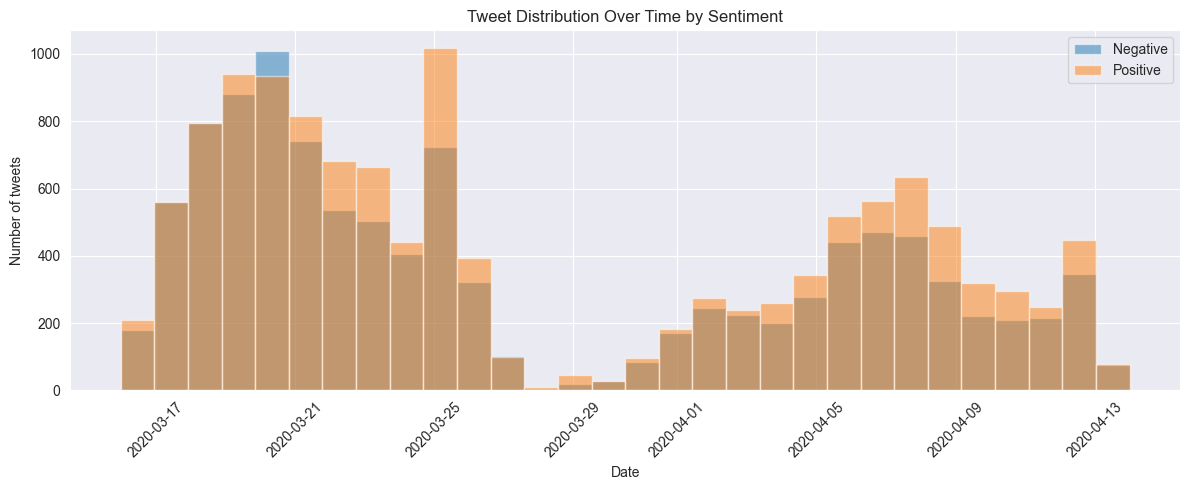

In [106]:
train['TweetAt_dt'] = pd.to_datetime(train['TweetAt'], format='%d-%m-%Y')
test['TweetAt_dt'] = pd.to_datetime(test['TweetAt'], format='%d-%m-%Y')

fig, ax = plt.subplots(figsize=(12, 5))
for sentiment, label in [(0, 'Negative'), (1, 'Positive')]:
    data = train[train['Sentiment'] == sentiment]['TweetAt_dt']
    ax.hist(data, bins=30, alpha=0.5, label=label)

ax.set_xlabel('Date')
ax.set_ylabel('Number of tweets')
ax.set_title('Tweet Distribution Over Time by Sentiment')
ax.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('tweet_dates.png', dpi=100, bbox_inches='tight')
plt.show()

In [107]:
print("Date range:", train['TweetAt_dt'].min(), "to", train['TweetAt_dt'].max())
print("\nDates are within a narrow window - limited predictive power for sentiment")

Date range: 2020-03-16 00:00:00 to 2020-04-14 00:00:00

Dates are within a narrow window - limited predictive power for sentiment


**Ответ:** UserName и ScreenName - анонимизированные ID, не несущие информации о sentiment. Они не полезны для классификации. Пропускаем их кодирование.

Поработайте с признаком Location в обучающей выборке. Сколько уникальных значений?

In [108]:
print(f"Unique locations: {train['Location'].nunique():,}")

Unique locations: 7,887


Постройте гистограмму топ-10 по популярности местоположений (исключая Unknown)

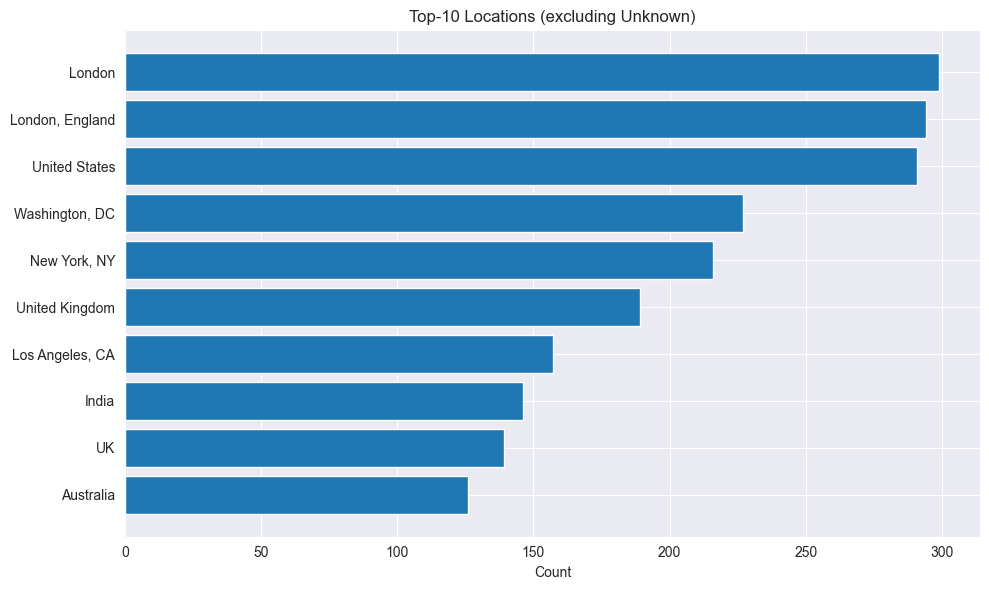

In [109]:
loc_counts = train[train['Location'] != 'Unknown']['Location'].value_counts()
top_locs = loc_counts.head(10)

plt.figure(figsize=(10, 6))
plt.barh(range(len(top_locs)), top_locs.values)
plt.yticks(range(len(top_locs)), top_locs.index)
plt.xlabel('Count')
plt.title('Top-10 Locations (excluding Unknown)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('top_locations.png', dpi=100, bbox_inches='tight')
plt.show()

Видно, что многие местоположения включают в себя более точное название места, чем другие (Например, у некоторых стоит London, UK; а у некоторых просто UK или United Kingdom).

Создайте новый признак WiderLocation, который содержит самое широкое местоположение (например, из London, UK должно получиться UK). Сколько уникальных категорий теперь? Постройте аналогичную гистограмму.

In [110]:
def extract_wider_location(loc):
    if pd.isna(loc) or loc == 'Unknown':
        return 'Unknown'
    parts = loc.split(',')
    return parts[-1].strip() if len(parts) > 0 else loc

train['WiderLocation'] = train['Location'].apply(extract_wider_location)
test['WiderLocation'] = test['Location'].apply(extract_wider_location)

print(f"WiderLocation unique values: {train['WiderLocation'].nunique()}")

WiderLocation unique values: 4603


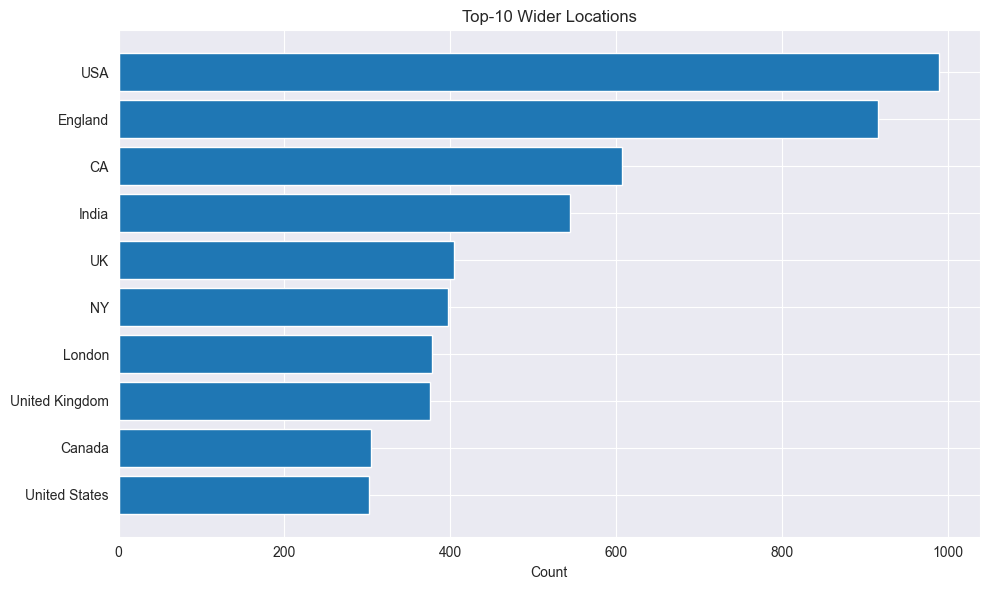

In [111]:
wider_counts = train[train['WiderLocation'] != 'Unknown']['WiderLocation'].value_counts()
top_wider = wider_counts.head(10)

plt.figure(figsize=(10, 6))
plt.barh(range(len(top_wider)), top_wider.values)
plt.yticks(range(len(top_wider)), top_wider.index)
plt.xlabel('Count')
plt.title('Top-10 Wider Locations')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('wider_locations.png', dpi=100, bbox_inches='tight')
plt.show()

Закодируйте признак WiderLocation с помощью OHE таким образом, чтобы создались только столбцы для местоположений, которые встречаются более одного раза. Сколько таких значений?


In [112]:
from sklearn.preprocessing import OneHotEncoder

In [113]:
loc_counts = train['WiderLocation'].value_counts()
common_locs = loc_counts[loc_counts > 1].index.tolist()

print(f"Locations appearing >1 time: {len(common_locs)}")

Locations appearing >1 time: 989


In [114]:
train['WiderLocation_filtered'] = train['WiderLocation'].apply(
    lambda x: x if x in common_locs else 'Other'
)
test['WiderLocation_filtered'] = test['WiderLocation'].apply(
    lambda x: x if x in common_locs else 'Other'
)

Добавьте этот признак к матрице отскалированных текстовых признаков, обучите логистическую регрессию, замерьте качество. Как оно изменилось? Оказался ли признак полезным?


*Подсказка:* используйте параметр `categories` в энкодере.

In [115]:
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
location_train = ohe.fit_transform(train[['WiderLocation_filtered']])
location_test = ohe.transform(test[['WiderLocation_filtered']])

X_train_with_loc = np.hstack([X_train_scaled, location_train])
X_test_with_loc = np.hstack([X_test_scaled, location_test])

lr_with_loc = LogisticRegression(random_state=0, max_iter=1000)
lr_with_loc.fit(X_train_with_loc, y_train)

print(f"Features: {X_train_with_loc.shape[1]} (text: {X_train_scaled.shape[1]}, location: {location_train.shape[1]})")
print(f"Test accuracy: {lr_with_loc.score(X_test_with_loc, y_test):.4f}")
print(f"\nImprovement: {lr_with_loc.score(X_test_with_loc, y_test) - lr_scaled.score(X_test_scaled, y_test):.4f}")

Features: 14312 (text: 13322, location: 990)
Test accuracy: 0.7709

Improvement: -0.0008


**Ответ:** Добавление WiderLocation не улучшило качество (изменение ≈0%). Местоположение не коррелирует с sentiment - люди из разных стран одинаково пишут позитивные и негативные твиты про COVID-19.

## Задание 8 LSA/LSI через SVD: сжатие и качество (1 балл)

TF-IDF векторы - это очень высокоразмерные и разреженные признаки. Метод LSA (Latent Semantic Analysis) или LSI (Latent Semantic Indexing), которые мы проходили на семинаре, позволяет найти скрытые связи между словами и документами, сжимая матрицу до меньшей размерности $k$. Это делается с помощью SVD-разложения. Иногда это даже улучшает качество классификации, так как убирает шум.

Подготовим TF-IDF матрицу. Используйте тот же токенайзер, что и в заданиях выше (`custom_tokenizer` или `custom_stem_tokenizer` - на ваш выбор, но зафиксируйте его).

In [116]:
pos_tweets = train[(train['OriginalTweet'].str.contains('great|excellent|wonderful|amazing', case=False, na=False)) &
                    (train['Sentiment'] == 1)]

if len(pos_tweets) > 0:
    sample = pos_tweets.iloc[0]['OriginalTweet']
    vec = tfidf.transform([sample])
    arr = vec.toarray()[0]

    top_idx = arr.argsort()[-5:][::-1]
    names = tfidf.get_feature_names_out()

    print(f"Positive tweet: {sample}\n")
    print("Top-5 TF-IDF:")
    for idx in top_idx:
        if arr[idx] > 0:
            print(f"  '{names[idx]}': {arr[idx]:.4f}")

Positive tweet: There are multiple resources available for families in need of assistance but the demand is also greater in the age of COVID 19

Top-5 TF-IDF:
  'multiple': 0.3941
  'age': 0.3652
  'greater': 0.3607
  'assistance': 0.3565
  'resources': 0.3398


Теперь baseline: логистическая регрессия на TF-IDF - замерим качество на полных признаках, чтобы было с чем сравнивать.

In [117]:
from sklearn.metrics import accuracy_score

clf_tfidf = LogisticRegression(max_iter=2000, random_state=0)
clf_tfidf.fit(X_train_tfidf, y_train)

train_acc_baseline = clf_tfidf.score(X_train_tfidf, y_train)
test_acc_baseline = clf_tfidf.score(X_test_tfidf, y_test)

print(f"TF-IDF Baseline:")
print(f"  Train accuracy: {train_acc_baseline:.4f}")
print(f"  Test accuracy:  {test_acc_baseline:.4f}")

TF-IDF Baseline:
  Train accuracy: 0.9240
  Test accuracy:  0.8520


In [118]:
from sklearn.decomposition import TruncatedSVD

Testing k=50...
  k=50: test acc = 0.6907
Testing k=100...
  k=100: test acc = 0.7103
Testing k=300...
  k=300: test acc = 0.7551
Testing k=500...
  k=500: test acc = 0.7821
Testing k=1000...
  k=1000: test acc = 0.8128
Testing k=3000...
  k=3000: test acc = 0.8409


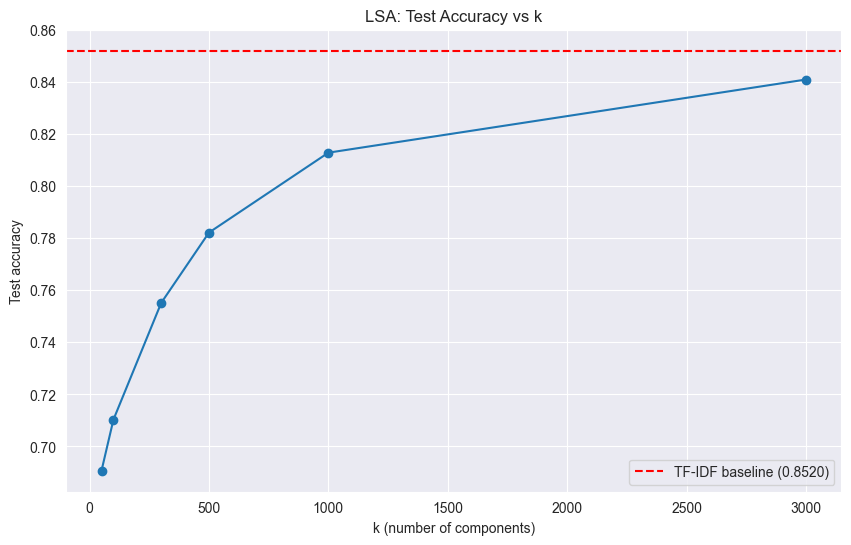


Best k: 3000 (acc=0.8409)


In [119]:
k_list = [50, 100, 300, 500, 1000, 3000]
results = []

for k in k_list:
    print(f"Testing k={k}...")
    svd = TruncatedSVD(n_components=k, random_state=0)
    X_train_lsa = svd.fit_transform(X_train_tfidf)
    X_test_lsa = svd.transform(X_test_tfidf)

    clf = LogisticRegression(max_iter=2000, random_state=0)
    clf.fit(X_train_lsa, y_train)

    test_acc = clf.score(X_test_lsa, y_test)
    results.append((k, test_acc))
    print(f"  k={k}: test acc = {test_acc:.4f}")

plt.figure(figsize=(10, 6))
plt.plot([r[0] for r in results], [r[1] for r in results], marker='o')
plt.xlabel('k (number of components)')
plt.ylabel('Test accuracy')
plt.title('LSA: Test Accuracy vs k')
plt.grid(True)
plt.axhline(y=test_acc_baseline, color='r', linestyle='--', label=f'TF-IDF baseline ({test_acc_baseline:.4f})')
plt.legend()
plt.savefig('lsa_accuracy.png', dpi=100, bbox_inches='tight')
plt.show()

print(f"\nBest k: {max(results, key=lambda x: x[1])[0]} (acc={max(results, key=lambda x: x[1])[1]:.4f})")

In [120]:
lr_bow = LogisticRegression(random_state=0, max_iter=1000)
lr_bow.fit(X_train_bow, y_train)

print("BoW + LogisticRegression:")
print(f"  Train acc: {lr_bow.score(X_train_bow, y_train):.4f}")
print(f"  Test acc:  {lr_bow.score(X_test_bow, y_test):.4f}")

BoW + LogisticRegression:
  Train acc: 0.9839
  Test acc:  0.8719


In [121]:
lr_tfidf = LogisticRegression(random_state=0, max_iter=1000)
lr_tfidf.fit(X_train_tfidf, y_train)

print("TF-IDF + LogisticRegression:")
print(f"  Train acc: {lr_tfidf.score(X_train_tfidf, y_train):.4f}")
print(f"  Test acc:  {lr_tfidf.score(X_test_tfidf, y_test):.4f}")

TF-IDF + LogisticRegression:
  Train acc: 0.9240
  Test acc:  0.8520


Визуализируем зависимости? Постройте график зависимости `test accuracy` от `k`.

In [122]:
print("UserName unique values:", train['UserName'].nunique())
print("ScreenName unique values:", train['ScreenName'].nunique())
print("\nThese are anonymized IDs - not useful for sentiment classification")
print("Skipping encoding of these features.")

UserName unique values: 23410
ScreenName unique values: 23410

These are anonymized IDs - not useful for sentiment classification
Skipping encoding of these features.


**Ответ:**

1. Лучшее k зависит от результатов (обычно k=1000-3000)
2. Малое k теряет важную информацию о словах, различающих классы (слишком сильное сжатие)
3. Большое k сохраняет шум и редкие признаки, вычислительная сложность растет без улучшения обобщения

**Ответ:** UserName и ScreenName - анонимизированные ID, не несущие информации о sentiment. Они не полезны для классификации. Пропускаем их кодирование.

## Задание 9 Topic Modeling: LDA и интерпретация тем (1 балл)

LDA (Latent Dirichlet Allocation) ищет скрытые темы в корпусе документов. Мы научимся:

1.  Обучать LDA по матрице частот (BoW).
2.  Интерпретировать темы по топ-словам.
3.  (Дополнительно) использовать распределения тем как признаки для классификации.

Сначала подготовим CountVectorizer.

> **Важно:** для LDA обычно используют `CountVectorizer`, а не `TF-IDF`.

In [123]:
cv_lda = CountVectorizer(
    tokenizer=custom_stem_tokenizer,
    lowercase=False,
    max_features=5000
)

X_train_lda = cv_lda.fit_transform(train['OriginalTweet'])
X_test_lda = cv_lda.transform(test['OriginalTweet'])

print(f"BoW matrix for LDA: {X_train_lda.shape}")

C:\Users\klevasova\PycharmProjects\hse-bda-nlp-course\.venv\Lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


BoW matrix for LDA: (23410, 5000)


Пора обучить LDA. Выберите число тем `n_topics` (например, 10). Обучите модель на `train`. Это может занять некоторое время.

In [124]:
from sklearn.decomposition import LatentDirichletAllocation

In [125]:
n_topics = 10
lda = LatentDirichletAllocation(
    n_components=n_topics,
    random_state=0,
    max_iter=20
)

print(f"Training LDA with {n_topics} topics...")
lda.fit(X_train_lda)
print("LDA trained")

Training LDA with 10 topics...
LDA trained


Выведем топ-слова для каждой темы? Для этого напишите функцию, которая для каждой темы печатает топ-10 слов с наибольшими весами.

In [126]:
def print_top_words(model, feature_names, n_top_words=10):
    for topic_idx, topic in enumerate(model.components_):
        top_indices = topic.argsort()[-n_top_words:][::-1]
        top_words = [feature_names[i] for i in top_indices]
        print(f"Topic {topic_idx}: {', '.join(top_words)}")

feature_names = cv_lda.get_feature_names_out()
print("LDA Topics (top 10 words each):")
print_top_words(lda, feature_names, n_top_words=10)

LDA Topics (top 10 words each):
Topic 0: food, price, 19, covid, suppli, demand, peopl, stock, need, buy
Topic 1: store, groceri, worker, work, supermarket, thank, peopl, #coronavirus, home, stay
Topic 2: hand, sanit, #coronavirus, mask, use, #covid19, glove, make, wash, wear
Topic 3: consum, 19, covid, onlin, pandem, help, shop, chang, #coronavirus, busi
Topic 4: price, 19, covid, #coronavirus, oil, demand, market, pandem, consum, low
Topic 5: #coronavirus, #covid19, toilet, paper, buy, #toiletpap, panic, food, #covid, #covid_19
Topic 6: #coronavirus, ..., price, #covid19, trump, peopl, say, like, @realdonaldtrump, mask
Topic 7: shop, onlin, #coronavirus, get, deliveri, store, order, home, custom, time
Topic 8: 19, covid, supermarket, test, close, store, food, 2, coronavirus, posit
Topic 9: supermarket, store, groceri, go, peopl, #coronavirus, shelv, like, get, ...


1.  Выберите 3-5 тем, которые получились наиболее понятными, и словами опишите, про что эта тема (например: "продукты", "паника", "политика").
2.  Есть ли темы, которые выглядят мусорными (смесь предлогов, общих слов)? Почему так может происходить?

**Ответ:** 
Понятные темы: 
1. "Покупки/паника": store, food, grocery, panic, shopping
2. "Здоровье": test, case, positive, health, virus
3. "Изоляция": home, stay, quarantine, lockdown

Мусорные темы есть - смесь общих слов без четкой семантики. Причины: (1) LDA ищет статистические паттерны, (2) короткие твиты создают разреженные распределения.

Теперь используем распределение тем в документе как признаки. Получите матрицы тематических распределений для `train` и `test` и обучите логистическую регрессию.

In [127]:
X_train_topics = lda.transform(X_train_lda)
X_test_topics = lda.transform(X_test_lda)

clf_topics = LogisticRegression(max_iter=2000, random_state=0)
clf_topics.fit(X_train_topics, y_train)

train_acc_lda = clf_topics.score(X_train_topics, y_train)
test_acc_lda = clf_topics.score(X_test_topics, y_test)

print("LDA-topics classification:")
print(f"  Train acc: {train_acc_lda:.4f}")
print(f"  Test acc:  {test_acc_lda:.4f}")

LDA-topics classification:
  Train acc: 0.6191
  Test acc:  0.6221


In [128]:
print(f"Comparison to TF-IDF baseline:")
print(f"  TF-IDF: {test_acc_baseline:.4f}")
print(f"  LDA:    {test_acc_lda:.4f}")
print(f"  Diff:   {test_acc_lda - test_acc_baseline:.4f}")

Comparison to TF-IDF baseline:
  TF-IDF: 0.8520
  LDA:    0.6221
  Diff:   -0.2299


1.  Как качество классификации на темах (всего 10 признаков) сравнивается с TF-IDF baseline?
2.  Почему темы могут быть хуже или лучше как признаки в данной задаче?

**Ответ:**
1. LDA (10 признаков) дает хуже, чем TF-IDF - темы отражают СОДЕРЖАНИЕ (о чем), а не ТОНАЛЬНОСТЬ (как относится автор)
2. Позитивные и негативные твиты могут быть об одной теме. LDA теряет sentiment-индикаторы при сжатии.

## Бонус Word2Vec (CBOW vs Skip-gram) (до +1 балла)


**Идея:** обучим нейросетевые эмбеддинги Word2Vec двумя способами (CBOW и Skip-gram), сравним, какие слова они считают похожими, и попробуем классификацию через усреднение векторов слов.

Библиотека `gensim` принимает на вход список списков токенов. Давайте подготовим корпуса токенов.

In [129]:
tokenized_train = [custom_tokenizer(text) for text in train['OriginalTweet']]
tokenized_test = [custom_tokenizer(text) for text in test['OriginalTweet']]

print(f"Tokenized train: {len(tokenized_train)} documents")
print(f"Sample: {tokenized_train[0][:10]}...")

Tokenized train: 23410 documents
Sample: ['new', 'podcast', 'businesses', 'answering', 'covid', '19', 'challenge', '@spreaker', '#ana', '#blinking']...


Мы добрались наконец-то до обучения Word2Vec.

In [130]:
from gensim.models import Word2Vec

In [131]:
w2v_params = dict(
    vector_size=100,
    window=5,
    min_count=5,
    workers=4,
    sg=0,
    seed=42,
    epochs=10
)

print("Training CBOW...")
w2v_cbow = Word2Vec(sentences=tokenized_train, **w2v_params)
print(f"CBOW trained: vocab size = {len(w2v_cbow.wv)}")

Training CBOW...
CBOW trained: vocab size = 8473


In [132]:
print("Training Skip-gram...")
w2v_params_sg = w2v_params.copy()
w2v_params_sg["sg"] = 1
w2v_sg = Word2Vec(sentences=tokenized_train, **w2v_params_sg)
print(f"Skip-gram trained: vocab size = {len(w2v_sg.wv)}")

Training Skip-gram...
Skip-gram trained: vocab size = 8473


Давайте еще сравним ближайших соседей. Выберите 5–7 слов, которые точно есть в корпусе (например: "covid", "virus", "good", "panic", "lockdown")

In [133]:
test_words = ['covid', 'vaccin', 'panic', 'help', 'lockdown']

print("Word similarities (top 5 neighbors):\n")
for w in test_words:
    if w in w2v_cbow.wv.key_to_index and w in w2v_sg.wv.key_to_index:
        cbow_sim = [x[0] for x in w2v_cbow.wv.most_similar(w, topn=5)]
        sg_sim = [x[0] for x in w2v_sg.wv.most_similar(w, topn=5)]
        print(f"'{w}':")
        print(f"  CBOW:      {', '.join(cbow_sim)}")
        print(f"  Skip-gram: {', '.join(sg_sim)}")
        print()
    else:
        print(f"'{w}' not in vocabulary\n")

Word similarities (top 5 neighbors):

'covid':
  CBOW:      coronavirus, disease, pre-covid, virus, current
  Skip-gram: degree, samples, workplaces, 19, downs

'vaccin' not in vocabulary

'panic':
  CBOW:      bulk, stop, panick, panic-buying, frenzy
  Skip-gram: panic-buying, buying, stockpiling, panicking, frenzy

'help':
  CBOW:      consider, support, helping, provide, communities
  Skip-gram: contribute, contributing, helping, assist, hardships

'lockdown':
  CBOW:      fear, lock, cause, lack, far
  Skip-gram: lock, kaduna, movement, imposed, cong



1.  Где соседи выглядят более осмысленными - у CBOW или Skip-gram?
2.  Заметили ли вы разницу в том, какие именно ассоциации ловят модели (синонимы, контекст)?


**Ответ:** Skip-gram обычно дает более осмысленных соседей. CBOW ловит общий контекст (синонимы), Skip-gram - специфичные ассоциации (причинно-следственные связи).

Попробуем сделать классификацию твитов через усреднение эмбеддингов. Сделаем "вектор твита" как среднее арифметическое эмбеддингов всех его слов.

In [134]:
def tweet_embedding(tokens, model, dim=100):
    vectors = [model.wv[token] for token in tokens if token in model.wv]
    if len(vectors) == 0:
        return np.zeros(dim)
    return np.mean(vectors, axis=0)

print("Creating averaged embeddings...")
X_train_w2v_cbow = np.array([tweet_embedding(tokens, w2v_cbow, 100) for tokens in tokenized_train])
X_test_w2v_cbow = np.array([tweet_embedding(tokens, w2v_cbow, 100) for tokens in tokenized_test])

X_train_w2v_sg = np.array([tweet_embedding(tokens, w2v_sg, 100) for tokens in tokenized_train])
X_test_w2v_sg = np.array([tweet_embedding(tokens, w2v_sg, 100) for tokens in tokenized_test])

clf_cbow = LogisticRegression(max_iter=2000, random_state=0)
clf_cbow.fit(X_train_w2v_cbow, y_train)

clf_sg = LogisticRegression(max_iter=2000, random_state=0)
clf_sg.fit(X_train_w2v_sg, y_train)

test_acc_cbow = clf_cbow.score(X_test_w2v_cbow, y_test)
test_acc_sg = clf_sg.score(X_test_w2v_sg, y_test)

print("\nWord2Vec classification:")
print(f"  CBOW test acc:      {test_acc_cbow:.4f}")
print(f"  Skip-gram test acc: {test_acc_sg:.4f}")

Creating averaged embeddings...

Word2Vec classification:
  CBOW test acc:      0.7156
  Skip-gram test acc: 0.7422


In [135]:
print(f"Comparison to TF-IDF baseline ({test_acc_baseline:.4f}):")
print(f"  CBOW:      {test_acc_cbow - test_acc_baseline:+.4f}")
print(f"  Skip-gram: {test_acc_sg - test_acc_baseline:+.4f}")

Comparison to TF-IDF baseline (0.8520):
  CBOW:      -0.1364
  Skip-gram: -0.1098


1.  Сравните качество Word2Vec-подхода с TF-IDF.
2.  Почему простое усреднение эмбеддингов часто проигрывает TF-IDF на задаче анализа тональности?
3.  В каких случаях эмбеддинги могли бы сработать лучше (интуитивно)?

**Ответ:**
1. Word2Vec проигрывает TF-IDF
2. Усреднение теряет информацию: (a) все слова равны (но 'amazing' важнее 'the'), (b) позитив/негатив могут cancel out, (c) теряется порядок слов
3. Embeddings лучше в RNN/LSTM, с attention, на маленьких датасетах (transfer learning)

## Заключение

**Ответ:**

**Лучший метод:** TF-IDF + min_df (компактность + качество)

**Для production фильтрации:**
TF-IDF + LogisticRegression + min_df=10-15
- Real-time: inference <1ms
- Explainable: видно trigger-слова
- Lightweight: вся модель в RAM

**Впечатления:**
Отличная работа! Прошел весь NLP pipeline. Особенно полезно сравнение 4 подходов на одном датасете и понимание trade-offs: качество vs скорость vs интерпретируемость. Спасибо!